<a href="https://colab.research.google.com/github/ibryegen/Deep_Learning/blob/main/EuroSAT_Land_Cover_Classification_with_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with EuroSAT Imagery

## Project Overview

In this project, we utilize EuroSAT satellite imagery to perform land cover classification using deep learning techniques. EuroSAT is a dataset derived from Sentinel-2 satellite images, encompassing a variety of land cover classes. Our goal is to leverage the power of convolutional neural networks (CNNs) to accurately classify these images.

We employ the ResNet50 architecture, known for its robustness in handling complex image classification tasks. This model consists of multiple convolutional and pooling layers, enabling it to learn intricate features from the input images. During the training process, the dataset is split into training and validation sets, and preprocessing steps such as rescaling are applied to the images.

This project demonstrates the effectiveness of deep learning models in performing land cover classification, a crucial task in remote sensing and geographical analysis. The code below visualizes the model's predictions compared to the true labels using matplotlib.

## Derin Öğrenme ile EuroSAT Görüntüleri

### Proje Genel Bakış

Bu projede, derin öğrenme teknikleri kullanarak EuroSAT uydu görüntüleri ile arazi örtüsü sınıflandırması gerçekleştiriyoruz. EuroSAT, Sentinel-2 uydu görüntülerinden elde edilen ve çeşitli arazi örtüsü sınıflarını içeren bir veri kümesidir. Amacımız, konvolüsyonel sinir ağlarının (CNN) gücünden yararlanarak bu görüntüleri doğru bir şekilde sınıflandırmaktır.

ResNet50 mimarisini kullanıyoruz, bu model karmaşık görüntü sınıflandırma görevlerinde dayanıklılığı ile bilinir. Model, giriş görüntülerinden karmaşık özellikleri öğrenmesini sağlayan birçok konvolüsyon ve havuzlama katmanından oluşur. Eğitim sürecinde veri kümesi eğitim ve doğrulama olarak bölünmüş, rescale gibi ön işleme adımları uygulanmıştır.

Bu proje, uzaktan algılama ve coğrafi analizlerde önemli bir görev olan arazi örtüsü sınıflandırmasında derin öğrenme modellerinin etkinliğini göstermektedir. Aşağıdaki kod, modelin tahmin ettiği etiketler ile gerçek etiketleri karşılaştırarak sonuçları matplotlib ile görselleştirmektedir.
**kalın metin**

In [1]:
# Essential and common packages
import os
import glob

# Plots and bars
import matplotlib.pyplot as plt

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
!unzip /content/EuroSAT.zip -d /content/EuroSAT

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_2206.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/EuroSAT/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/EuroSA

In [3]:
dataset_url = "/content/EuroSAT/2750"
batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0/255

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [5]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')


test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


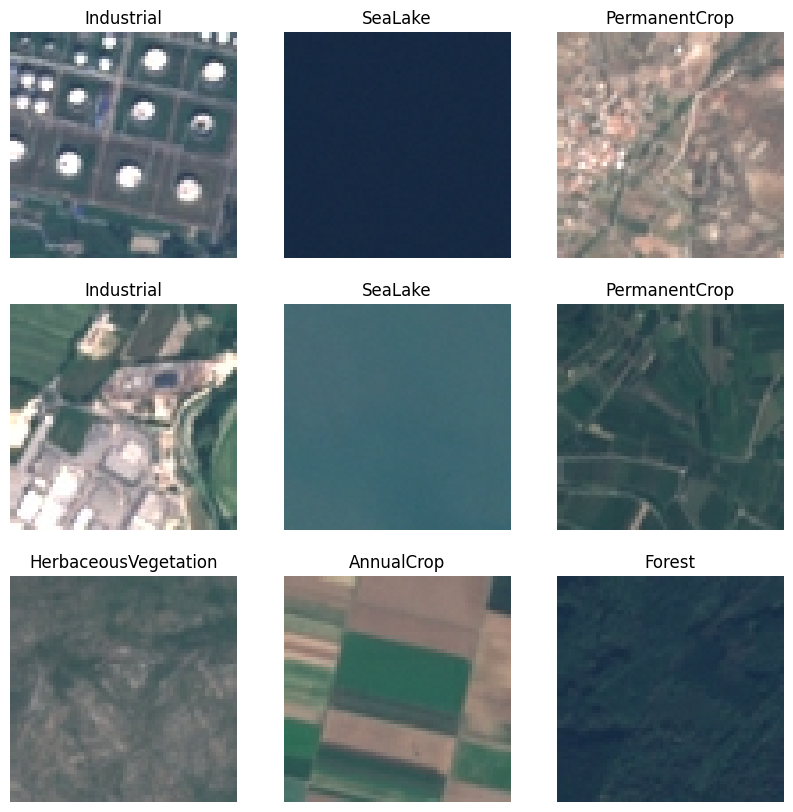

In [6]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
from tensorflow.keras.initializers import random_uniform, glorot_uniform

In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
model = ResNet50(input_shape=(64,64,3), classes=10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
675/675 [==============================] - 30s 45ms/step - loss: 0.8820 - accuracy: 0.7096 - val_loss: 1.0103 - val_accuracy: 0.6746
Epoch 2/20
675/675 [==============================] - 30s 45ms/step - loss: 0.7918 - accuracy: 0.7422 - val_loss: 0.9610 - val_accuracy: 0.6806
Epoch 3/20
675/675 [==============================] - 31s 45ms/step - loss: 0.8753 - accuracy: 0.7326 - val_loss: 2.1643 - val_accuracy: 0.3752
Epoch 4/20
675/675 [==============================] - 31s 45ms/step - loss: 1.2902 - accuracy: 0.5764 - val_loss: 0.8947 - val_accuracy: 0.6756
Epoch 5/20
675/675 [==============================] - 30s 45ms/step - loss: 0.7928 - accuracy: 0.7282 - val_loss: 0.7983 - val_accuracy: 0.7387
Epoch 6/20
675/675 [==============================] - 30s 45ms/step - loss: 0.7167 - accuracy: 0.7605 - val_loss: 0.6254 - val_accuracy: 0.7833
Epoch 7/20
675/675 [==============================] - 30s 45ms/step - loss: 0.6369 - accuracy: 0.7800 - val_loss: 0.7311 - val_accuracy:

In [17]:
model.save(r'model/model_100_epoch.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from tensorflow.keras.models import load_model
model = load_model(r"model/model_100_epoch.h5")

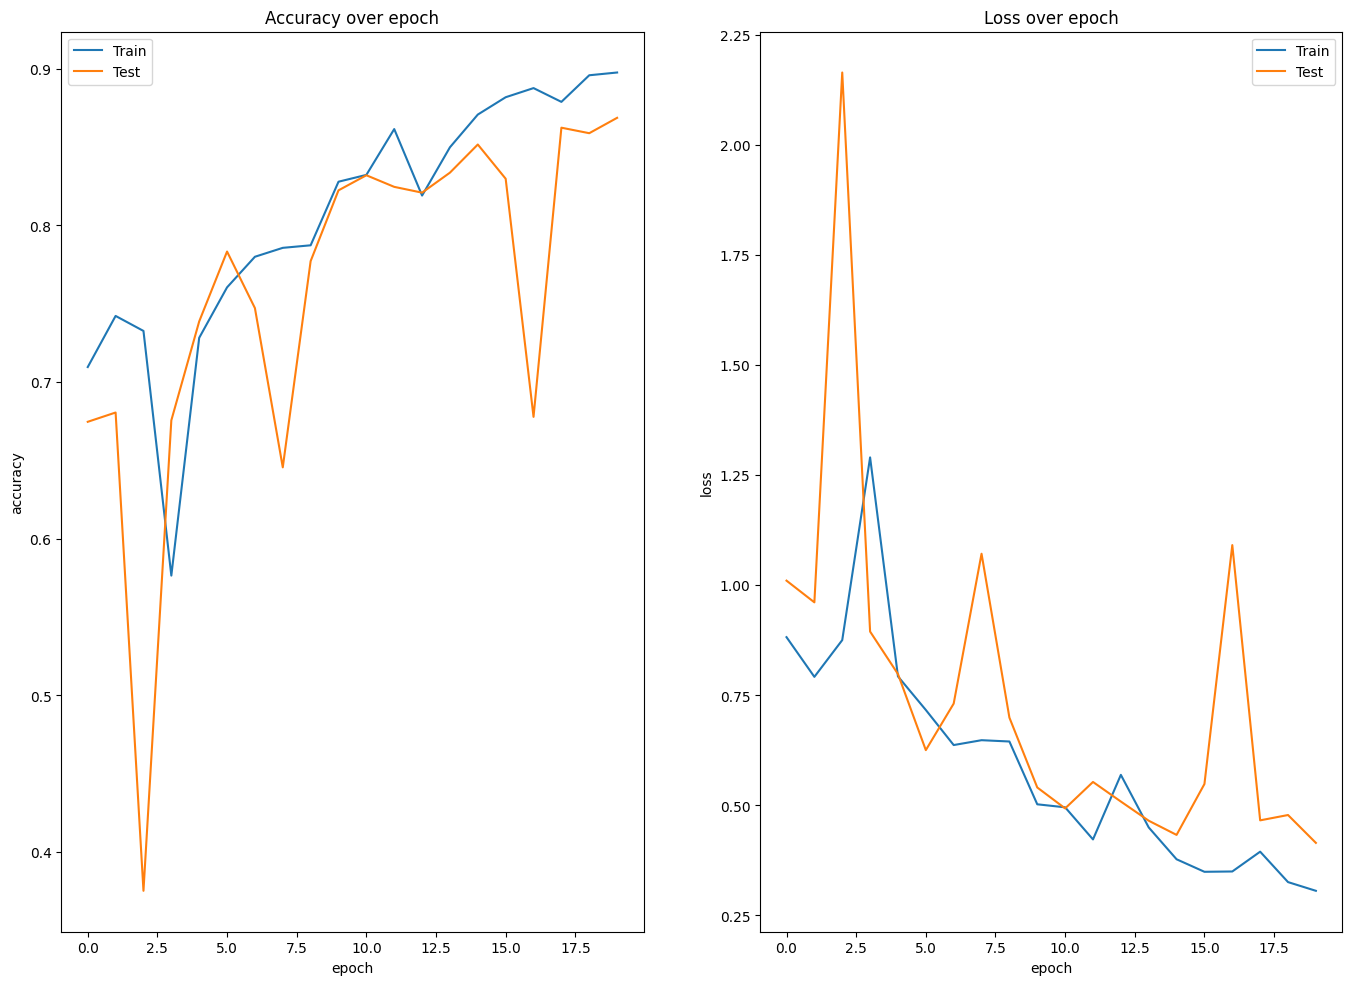

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [20]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 28ms/step


In [21]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 928,    9,   14,   14,    1,   32,   35,    2,   29,   13],
       [   0, 1046,    8,    0,    0,    6,    1,    1,    1,    8],
       [  24,   32,  893,    6,   16,   11,   73,    8,    9,    7],
       [   6,    2,   22,  748,   32,    7,   12,   19,   36,    0],
       [   0,    0,   17,   14,  764,    0,    3,   78,    6,    0],
       [  15,   71,   17,   14,    0,  536,   17,    3,   28,    2],
       [  40,    4,  119,   18,    9,   34,  646,   20,    8,    0],
       [   0,    1,   15,    1,   10,    0,    3, 1033,    0,    0],
       [  26,   10,   24,   52,    6,   23,   10,    0,  745,    2],
       [   2,   41,    4,    1,    0,    5,    0,    0,   12, 1004]])

In [22]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 928    9   14   14    1   32   35    2   29   13]
 [   0 1046    8    0    0    6    1    1    1    8]
 [  24   32  893    6   16   11   73    8    9    7]
 [   6    2   22  748   32    7   12   19   36    0]
 [   0    0   17   14  764    0    3   78    6    0]
 [  15   71   17   14    0  536   17    3   28    2]
 [  40    4  119   18    9   34  646   20    8    0]
 [   0    1   15    1   10    0    3 1033    0    0]
 [  26   10   24   52    6   23   10    0  745    2]
 [   2   41    4    1    0    5    0    0   12 1004]]


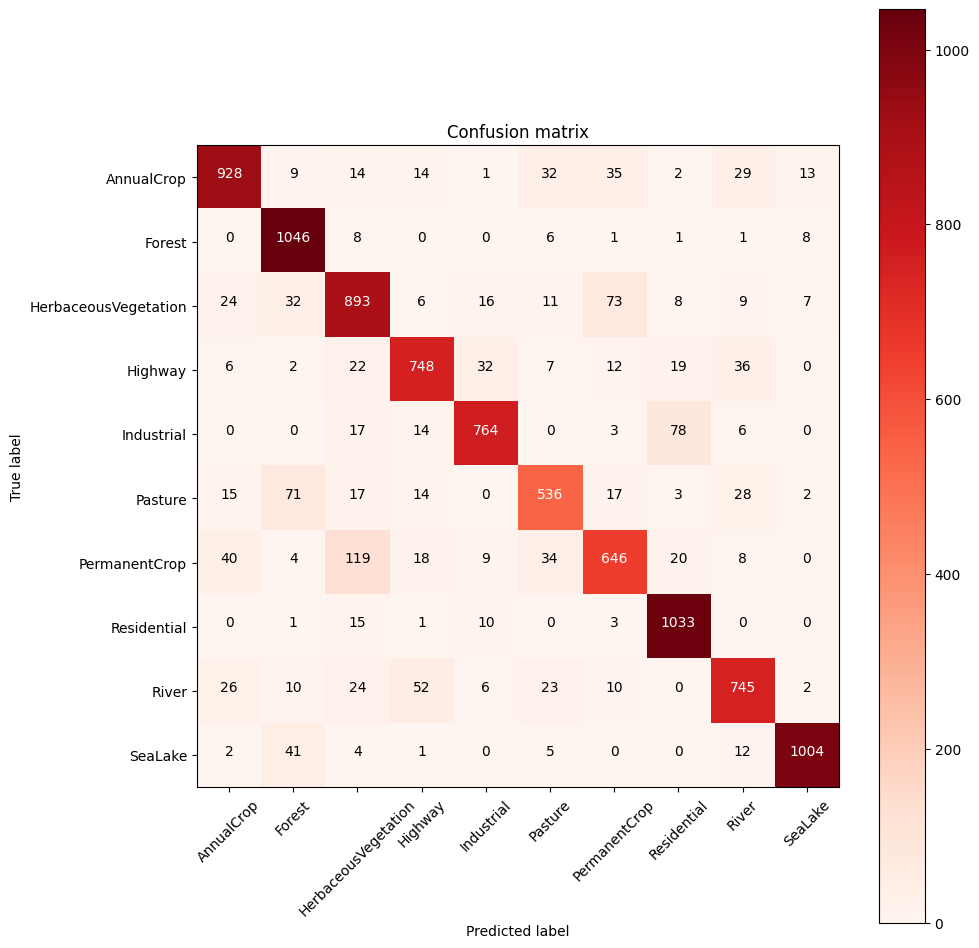

In [23]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

1/1 [==============================] - 0s 30ms/step


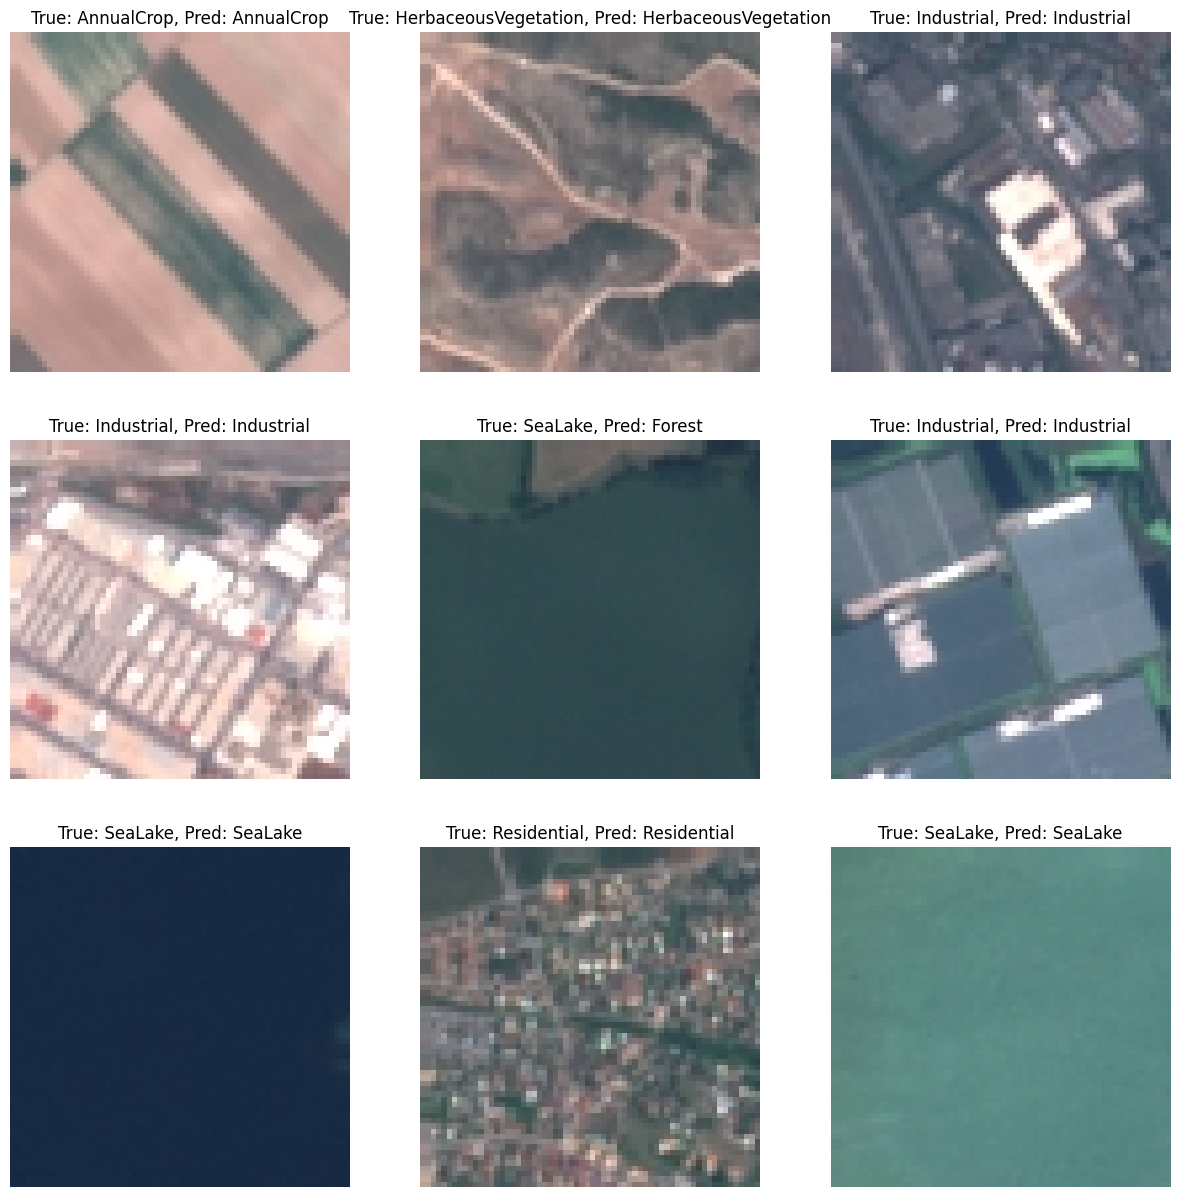

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Birkaç görüntü ve tahmin alma
num_images = 9
images, labels = next(test_dataset)
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

# Görüntüleri ve etiketleri görselleştir
plt.figure(figsize=(15, 15))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {class_names[true_labels[i]]}, Pred: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.show()
